# 3. Grad-CAM

### Model Interpretation using Grad-CAM (Gradient-weighted Class Activation Mapping) on a Convolutional Neural Network (CNN).

- **Creating Grad-CAM Heatmaps**: Grad-CAM is used to visualize the regions in the image that the model finds significant for making predictions. This is achieved by computing gradients of the predicted class with respect to the feature maps of a convolutional layer, followed by a weighted combination.

- **Overlaying Heatmaps**: The heatmaps are superimposed on the original images to highlight the important areas that contributed to the model's prediction.

- **Directory Management**: Directories are created to store visualizations of correct and incorrect predictions, providing an organized structure to analyze the results.

- **Prediction Details Retrieval**: Information related to the test image, predicted class, actual class, and predicted class index is gathered for visualization.

- **Saving Plots**: Plots of original test images and their corresponding heatmaps are saved to appropriate directories, distinguishing between correct and incorrect predictions.

- **Looping Through Models**: Multiple models can be visualized by looping through a dictionary containing model information and associated convolutional layers.

In [41]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

In [2]:
X_test = np.load('data/preproc_data/X_test.npy')
y_test = np.load('data/preproc_data/y_test.npy')
model_v1 = load_model('model/model_v1.h5')
model_v2 = load_model('model/model_v2.h5')

In [3]:
class_mapping = np.load('data/preproc_data/class_mapping.npy', allow_pickle=True).item()
reverse_class_mapping = {i: class_name for class_name, i in class_mapping.items()}

In [4]:
def create_gradcam(img_array, model, layer, pred_index):
    """
    This function creates a Grad-CAM (Gradient-weighted Class Activation Mapping) 
    which is a technique for visualizing the locations in the image that the model 
    considers important for making predictions.

    Args:
        img_array (numpy.ndarray): The input image.
        model (tf.keras.Model): The pre-trained model.
        layer (str): The name of the layer to use for the Grad-CAM.
        pred_index (int): Uses the class with the highest predicted probability.
    """

    # Create a model that returns the activations for the specified layer and the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate the gradients of the class_channel with respect to the activations of the specified layer
    grads = tape.gradient(class_channel, layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Perform the weighted combination of the feature maps based on the gradients
    heatmap = layer_output @ pooled_grads[..., tf.newaxis]

    # Remove all the dimensions of size 1 from the heatmap
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap such that all values lie in the range [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [42]:
def overlay_heatmap(heatmap, original_image):
    
    """
    Overlays a heatmap onto the original image, highlighting the important regions.

    Args:
        heatmap (numpy.ndarray): The heatmap, representing the importance of regions in the image.
        original_image (numpy.ndarray): The original image onto which the heatmap will be overlaid.

    Returns:
        superimposed_img: The original image with the heatmap overlaid.
    """
    
    heatmap = np.uint8(255 * heatmap)
    cmap = plt.colormaps.get_cmap("jet")
    cmap_colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = cmap_colors[heatmap]

    cmap_heatmap = array_to_img(cmap_heatmap)
    cmap_heatmap = cmap_heatmap.resize((original_image.shape[1], original_image.shape[0]))
    cmap_heatmap = img_to_array(cmap_heatmap)

    superimposed_img = cmap_heatmap * 0.3 + original_image
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

In [6]:
random_indices = random.sample(range(len(X_test)), 20)
reverse_class_mapping = {i: class_name for class_name, i in class_mapping.items()}

IMAGE_SIZE = (224, 224)

In [14]:
models_info = {
    "model_v1": {
        "model": load_model('model/model_v1.h5'),
        "conv_layer": "Convolution-3"
    },
    "model_v2": {
        "model": load_model('model/model_v2.h5'),
        "conv_layer": "Convolution-4"
    }
}

In [35]:
def make_directories(model_name):
    
    """
    Creates directories to store images of correct and wrong predictions for a given model.

    Args:
        model_name (str): The name of the model for which the directories are being created.

    Returns:
        correct_dir (str): Path to the directory where images of correct predictions will be stored.
        wrong_dir (str): Path to the directory where images of wrong predictions will be stored.
    """
    
    correct_dir = f'images/{model_name}/correct_predictions'
    wrong_dir = f'images/{model_name}/wrong_predictions'
    os.makedirs(correct_dir, exist_ok=True)
    os.makedirs(wrong_dir, exist_ok=True)
    return correct_dir, wrong_dir

In [40]:
def get_prediction_details(i, model):
    
    """
    Retrieves the details of a prediction for a given test image using the specified model.

    Args:
        i (int): Index of the test image in the test dataset.
        model (tf.keras.Model): The pre-trained model to use for prediction.

    Returns:
        test_image (numpy.ndarray): The test image used for prediction.
        predicted_class (str): The predicted class name.
        actual_class (str): The actual class name of the test image.
        predicted_class_index (int): The index of the predicted class.
    """
  
    test_image = X_test[i]
    result = model.predict(np.expand_dims(test_image, axis=0))
    predicted_class_index = np.argmax(result[0])
    predicted_class = reverse_class_mapping[predicted_class_index]
    actual_class_index = np.argmax(y_test[i])
    actual_class = reverse_class_mapping[actual_class_index]
    return test_image, predicted_class, actual_class, predicted_class_index

In [17]:
def save_plot(correct_dir, wrong_dir, predicted_class, actual_class, idx, test_image, superimposed_img):
    
    """
    Saves a side-by-side plot of the original test image and the superimposed image (with heatmap)
    to the correct directory if the prediction is correct, or to the wrong directory if incorrect.

    Args:
        correct_dir (str): The directory path to save plots of correct predictions.
        wrong_dir (str): The directory path to save plots of incorrect predictions.
        predicted_class (str): The class predicted by the model.
        actual_class (str): The actual class of the image.
        idx (int): Index or identifier for the image.
        test_image (numpy.ndarray): The original test image.
        superimposed_img: The original image with the heatmap overlaid.

    """
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(test_image[0])
    axs[0].set_title(f"Actual: {actual_class}\n Predicted: {predicted_class}")
    axs[0].axis('off')

    axs[1].imshow(superimposed_img)
    axs[1].set_title(f"Heatmap")
    axs[1].axis('off')
    
    if predicted_class == actual_class:
        plt.savefig(f"{correct_dir}/correct_pred_{idx}.png")
    else:
        plt.savefig(f"{wrong_dir}/wrong_pred_{idx}.png")
    plt.close(fig)

In [18]:
for model_name, model_info in models_info.items():
    model = model_info["model"]
    conv_layer = model_info["conv_layer"]
    correct_dir, wrong_dir = make_directories(model_name)
    
    for idx, i in enumerate(random_indices):
        test_image, predicted_class, actual_class, predicted_class_index = get_prediction_details(i, model)

        print(f"Predicted: {predicted_class}")
        print(f"Actual: {actual_class}")

        test_image = np.expand_dims(test_image, axis=0)
        heatmap = create_gradcam(test_image, model, conv_layer, predicted_class_index)
        heatmap = cv2.resize(heatmap, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        test_image_plot = (X_test[i] * 255).astype(np.uint8)
        superimposed_img = overlay_heatmap(heatmap, test_image_plot)

        save_plot(correct_dir, wrong_dir, predicted_class, actual_class, idx, test_image, superimposed_img)

1/1 [==============================] - 0s 42ms/step
Predicted: speedLimit25
Actual: speedLimit25
1/1 [==============================] - 0s 12ms/step
Predicted: keepRight
Actual: keepRight
1/1 [==============================] - 0s 12ms/step
Predicted: signalAhead
Actual: signalAhead
1/1 [==============================] - 0s 12ms/step
Predicted: signalAhead
Actual: signalAhead
1/1 [==============================] - 0s 13ms/step
Predicted: merge
Actual: merge
1/1 [==============================] - 0s 12ms/step
Predicted: stop
Actual: stop
1/1 [==============================] - 0s 12ms/step
Predicted: keepRight
Actual: keepRight
1/1 [==============================] - 0s 12ms/step
Predicted: stop
Actual: stop
1/1 [==============================] - 0s 12ms/step
Predicted: stop
Actual: stop
1/1 [==============================] - 0s 12ms/step
Predicted: speedLimit25
Actual: speedLimit25
1/1 [==============================] - 0s 12ms/step
Predicted: keepRight
Actual: keepRight
1/1 [============

## Correct Predictions

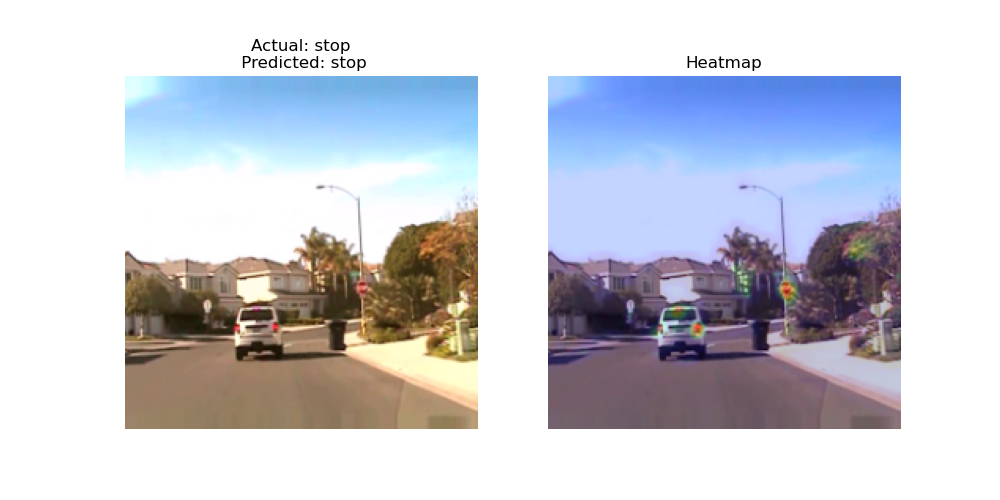

In [19]:
Image.open('images/presentation/correct/correct_stop1.png')

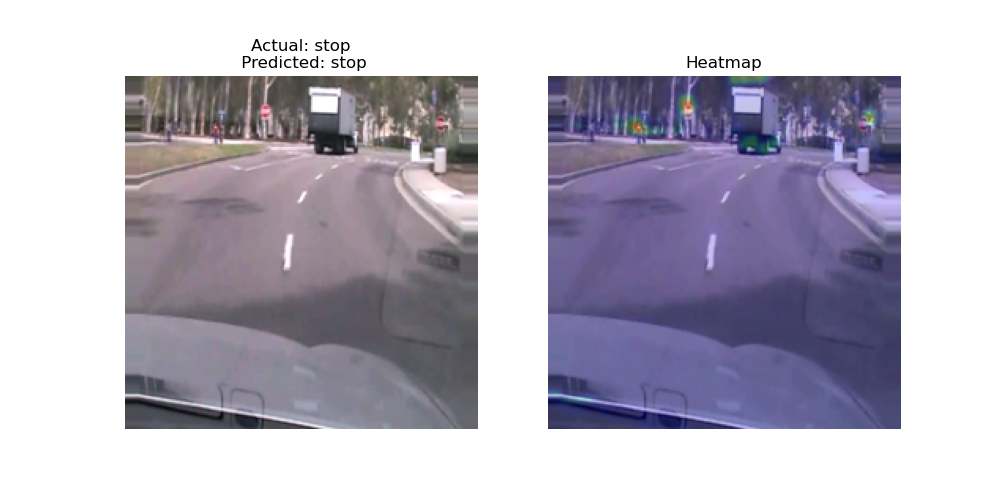

In [20]:
Image.open('images/presentation/correct/correct_stop4.png')

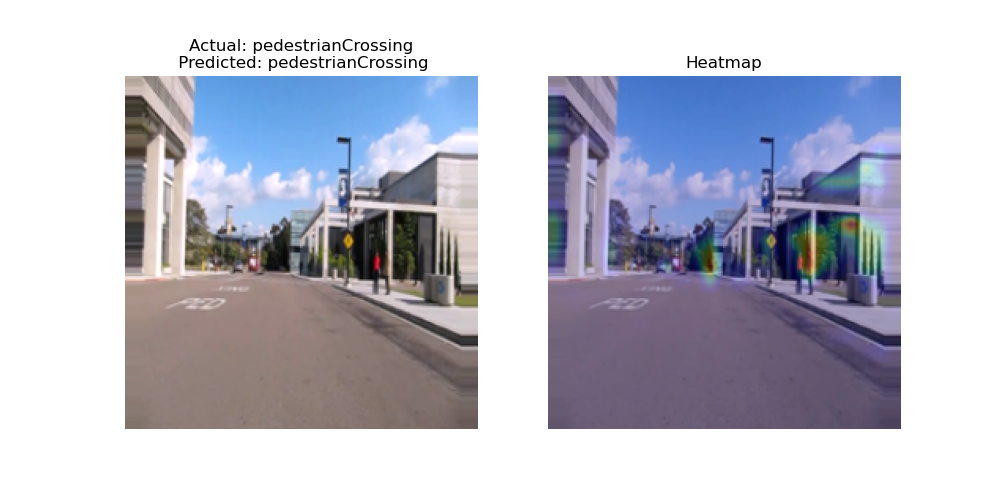

In [21]:
Image.open('images/presentation/correct/correct_pedest2.png')

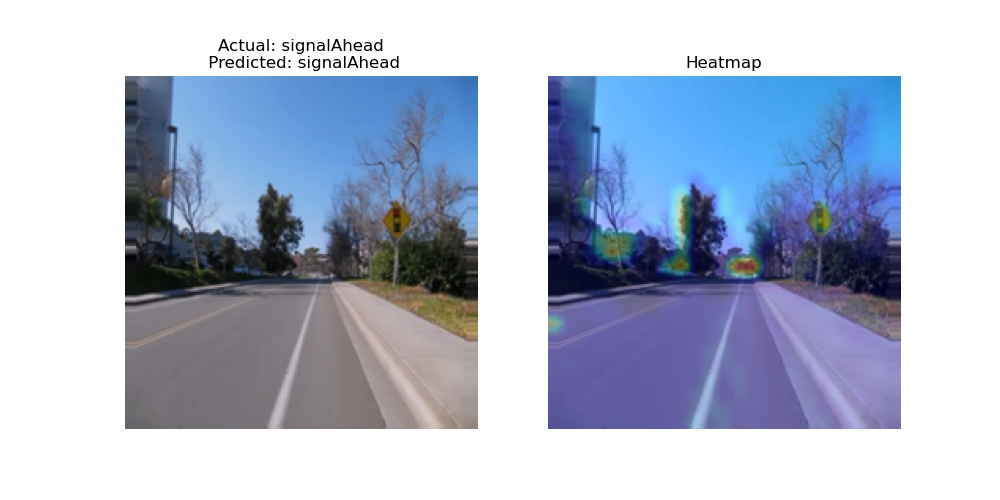

In [22]:
Image.open('images/presentation/correct/correct_signal2.png')

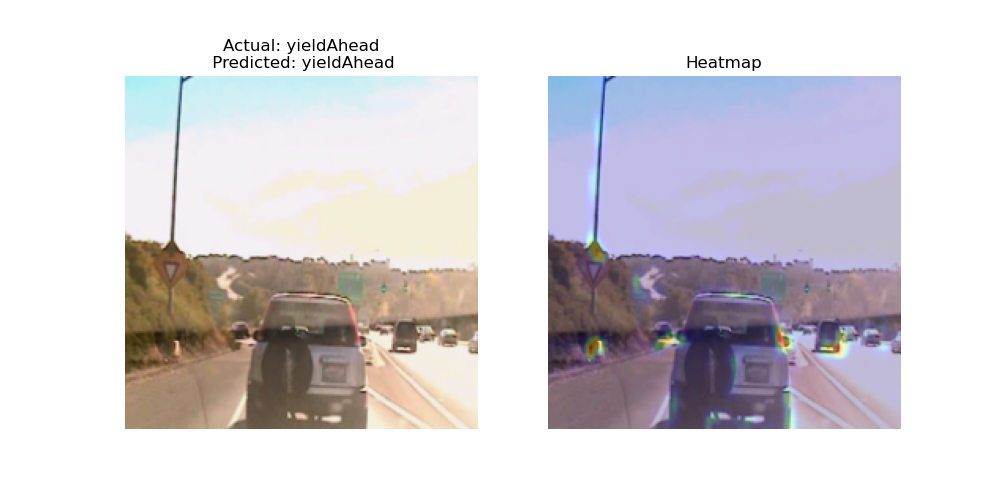

In [23]:
Image.open('images/presentation/correct/correct_yield3.png')

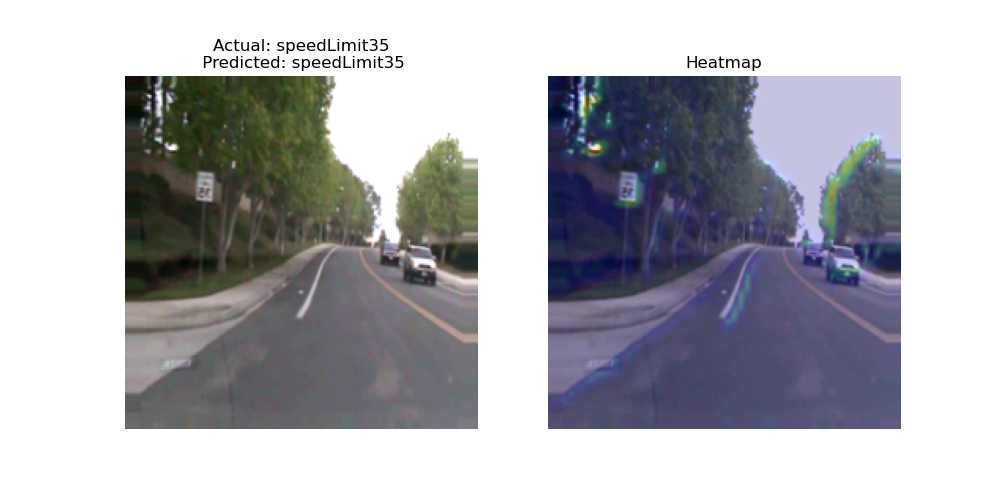

In [24]:
Image.open('images/presentation/correct/correct_352.png')

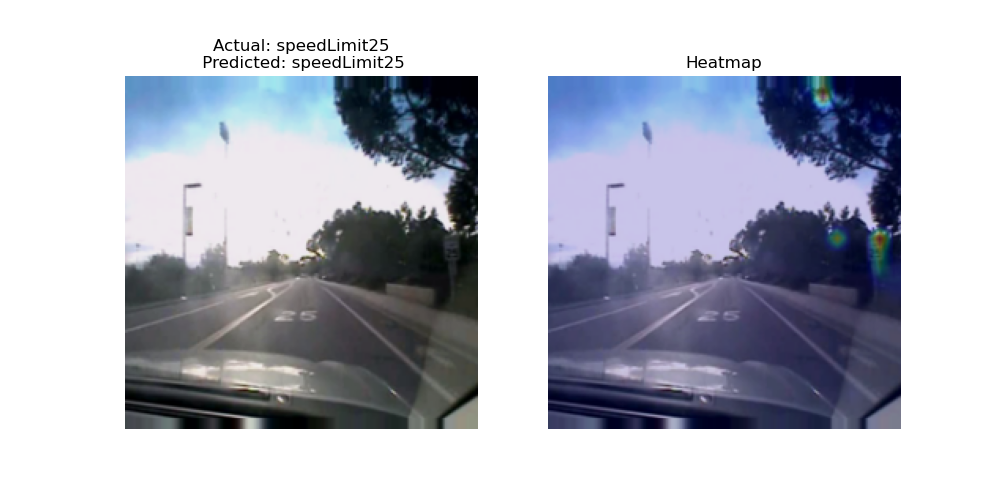

In [25]:
Image.open('images/presentation/correct/correct_speed254.png')

## Wrong Predictions

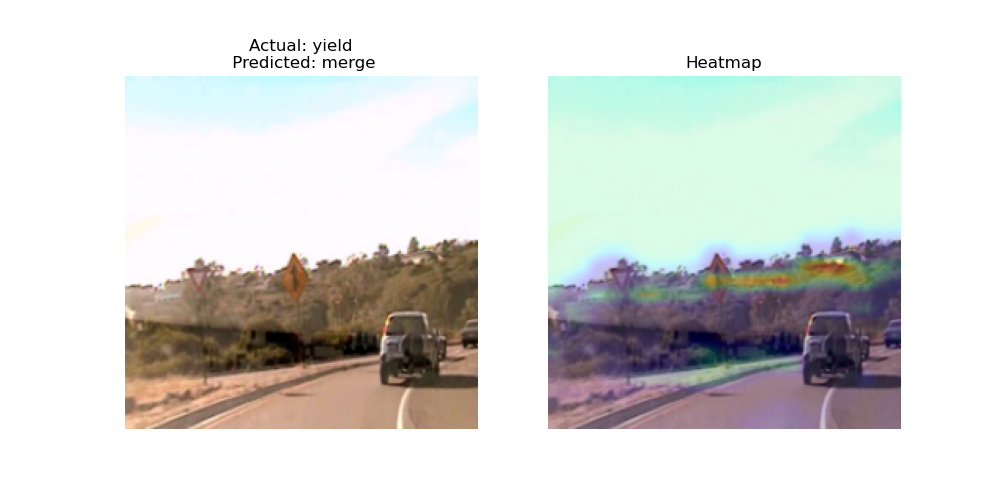

In [26]:
Image.open('images/presentation/wrong/wrong_1.png')

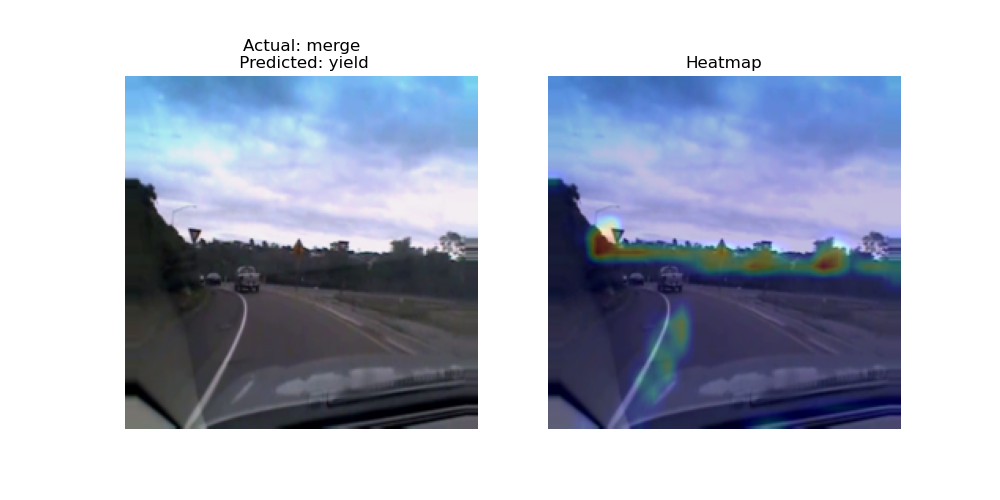

In [27]:
Image.open('images/presentation/wrong/wrong_2.png')

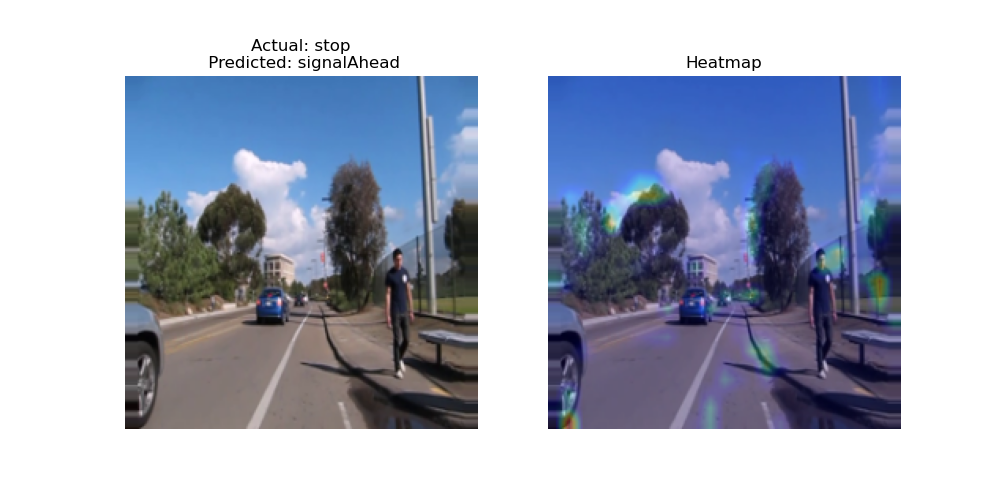

In [28]:
Image.open('images/presentation/wrong/wrong_3.png')

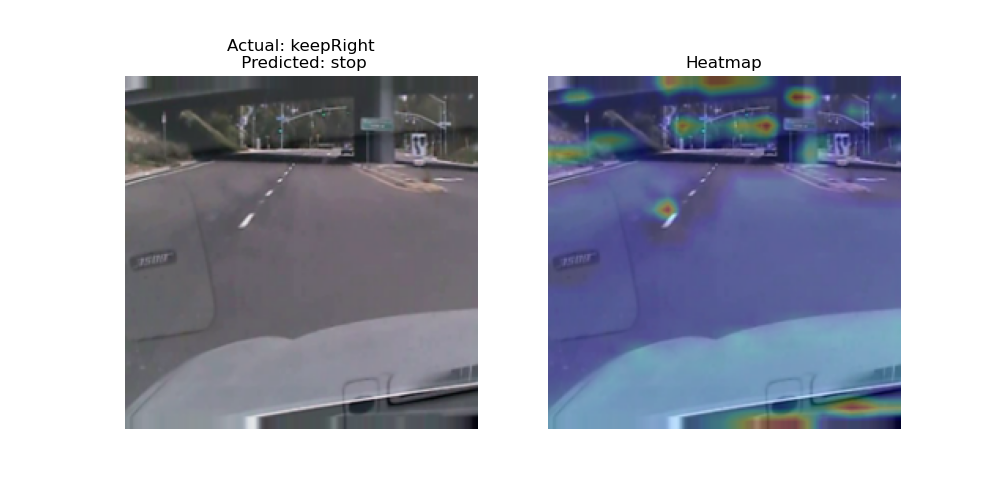

In [29]:
Image.open('images/presentation/wrong/wrong_4.png')

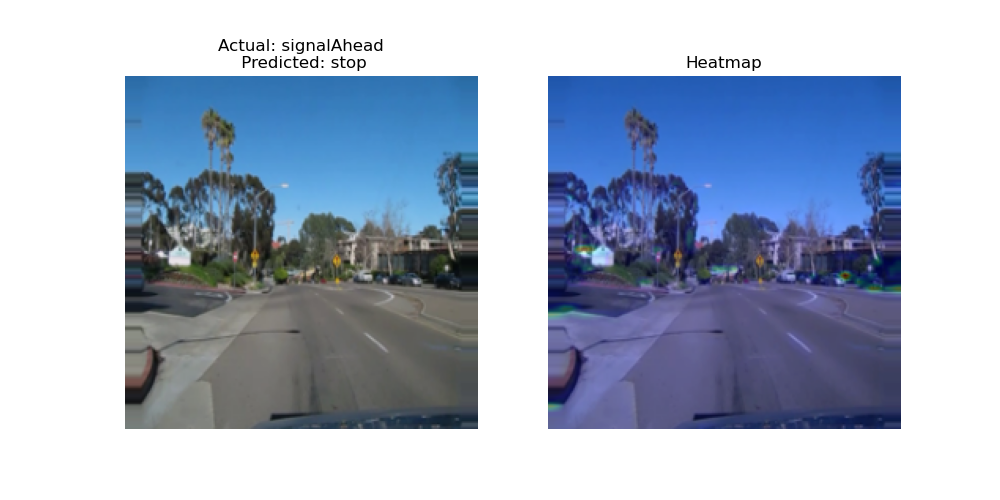

In [30]:
Image.open('images/presentation/wrong/wrong_5.png')

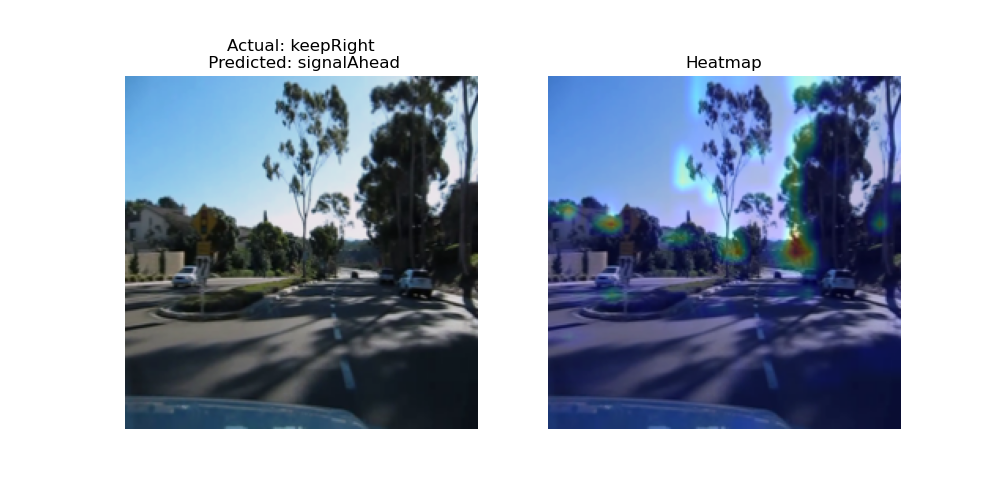

In [31]:
Image.open('images/presentation/wrong/wrong_6.png')

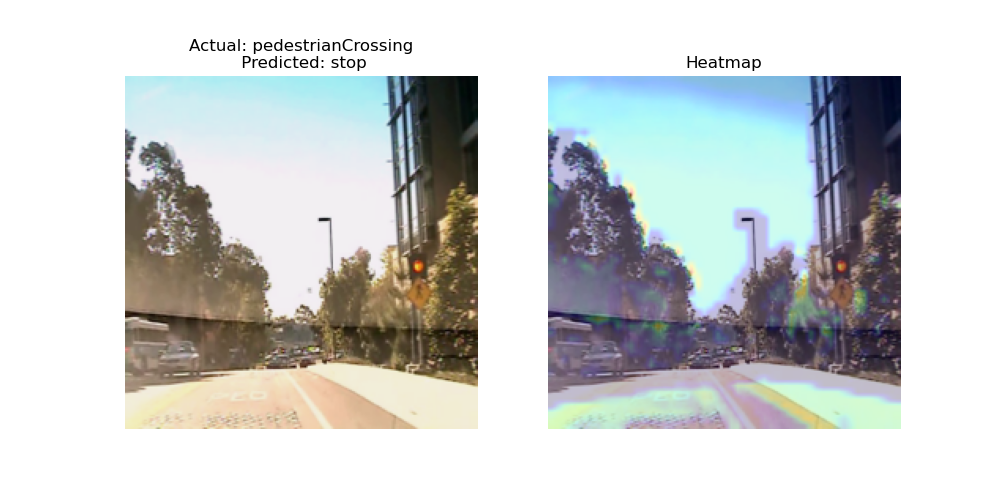

In [32]:
Image.open('images/presentation/wrong/wrong_7.png')

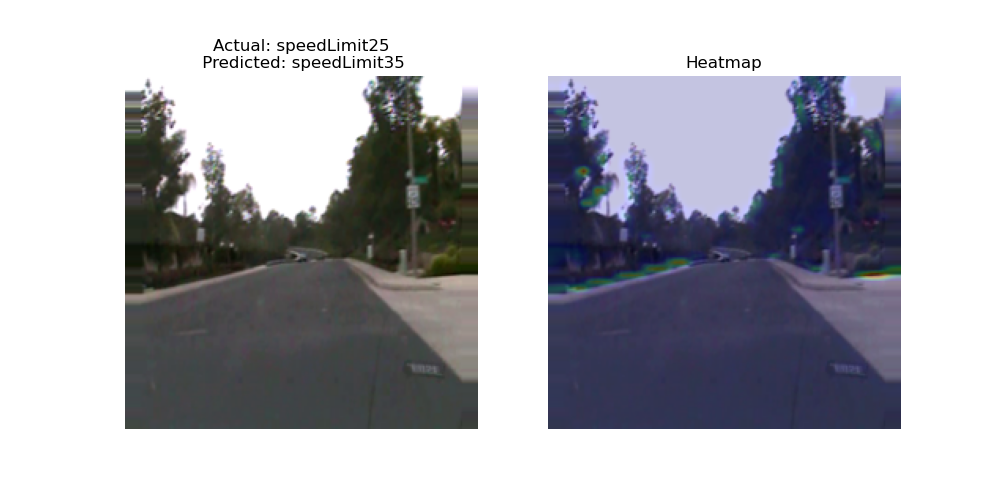

In [33]:
Image.open('images/presentation/wrong/wrong_9.png')